### langgraph 기본 그래프 생성

1. State 정의
2. 노드 정의
3. 그래프 정의
4. 그래프 컴파일
5. 그래프 시각화

In [4]:
!pip install -r requirements.txt

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/34.7 MB ? eta -:--:--
     ---------------- ---------------------- 14.4/34.7 MB 69.7 MB/s eta 0:00:01
     ------------------------------------- - 33.6/34.7 MB 78.9 MB/s eta 0:00:01
     --------------------------------------- 34.7/34.7 MB 73.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/981.5 kB ? eta -:--:--
     -----------------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.26.4 which is incompatible.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 24.1.0 which is incompatible.


In [2]:
# State정의(아래는 형태를 적어놓았을뿐 실제값이나 변수를 입력하여 작성한것은 아님)

from typing import TypedDict, Annotated, List
from langchain_core.documents import Document
import operator

class GraphState(TypedDict):
    context : Annotated[List[Document], operator.add]  # 리스트는 애드가 가능
    answer : Annotated[List[Document], operator.add]
    question : Annotated[str,"user question"]          # 문자열에는 애드가 안되니 그냥 정의문을 써둠둠
    sql_query : Annotated[str,"sql query"]
    binary_score : Annotated[str,"binary score yes or no"]

In [3]:
# 노드정의(아래는 형태를 적어 놓았을뿐 실제값이나 변수를 입력하여 작서한것은 아님)
# 노드는 기본적으로 함수구조로 정의한다.

def retrive(state:GraphState) -> GraphState:
    # retrive : 검색 기능 노드
    documents = "검색된 문서"
    return {"context" : documents}   # 입력도 state고 출력도 state이지만 key/value형태로 해도 된다 사실상 같은거다

def rewrite_query(state:GraphState) -> GraphState:
    # Query Transform : 쿼리 재작성
    documents = "검색된 문서"
    return GraphState(context=documents) # 이렇게 반환을 하는것이 정석같은거니 이구조가 좋다

def llm_gpt_execute(state:GraphState) -> GraphState:
    # LLM 실행
    answer = "GPT 생성된 답변"
    return GraphState(answer=answer)

def llm_claude_execute(state:GraphState) -> GraphState:
    # LLM 실행
    answer = "Claude 생성된 답변"
    return GraphState(answer=answer)

def relevance_check(state:GraphState) -> GraphState:
    # Relevance Check : 관련성 확인
    binary_score = "Relevance Score"
    return GraphState(binary_score=binary_score)

def sum_up(state:GraphState) -> GraphState:
    # sum_up : 결과 종합
    answer = "종합된 답변"
    return GraphState(answer=answer)

def search_on_web(state:GraphState) -> GraphState:
    # Search on web : 웹 검색
    documents = state["context"] = "기존문서"
    searched_documents = "검색된 문서"
    documents += searched_documents
    return GraphState(context=documents)

def get_table_info(state:GraphState) -> GraphState:
    # get table info : 테이블 정보 가져오기
    table_info = "테이블 정보"
    return GraphState(context=table_info)

def generate_sql_query(state : GraphState) -> GraphState:
    # Make SQL Query : SQL 쿼리 생성
    sql_query = "SQL 쿼리"
    return GraphState(sql_query=sql_query)

def execute_sql_query(state : GraphState) -> GraphState:
    # Execute SQL Query : SQL 쿼리 실행
    sql_result = "SQL 결과"
    return GraphState(context=sql_result)

def validate_sql_query(state : GraphState) -> GraphState:
    # Validate SQL Query : SQL 쿼리 검증
    binary_score = "SQL 쿼리 검증 결과"
    return GraphState(binary_score=binary_score)

def handle_error(stest:GraphState) -> GraphState:
    # Error handling : 에러처리
    error = "에러 발생"
    return GraphState(context=error)

def decision(state:GraphState) -> GraphState:
    # 의사결정
    decision = "결정"
    return decision

### 1. 가장간단한 구조인 conventional RAG

In [4]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

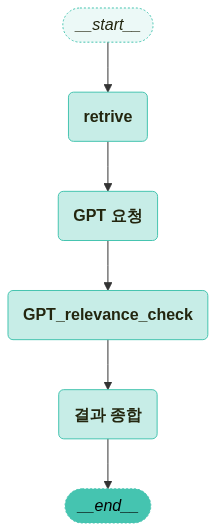

In [5]:
#langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드를 추가 합니다.
workflow.add_node("retrive", retrive)
workflow.add_node("GPT 요청",llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)

# 각 노드를 연결 합니다.
workflow.add_edge("retrive","GPT 요청")
workflow.add_edge("GPT 요청","GPT_relevance_check")
workflow.add_edge("GPT_relevance_check","결과 종합")
workflow.add_edge("결과 종합",END)

workflow.set_entry_point("retrive")
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

visualize_graph(app)

### 2. 1번의 기본 conventional RAG에 재검색 하는 로직 추가

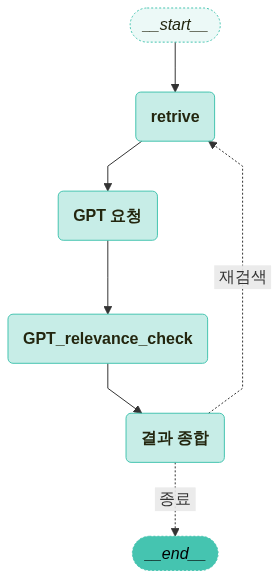

In [6]:
#langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드를 추가 합니다.
workflow.add_node("retrive", retrive)
workflow.add_node("GPT 요청",llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)

# 각 노드를 연결 합니다.
workflow.add_edge("retrive","GPT 요청")
workflow.add_edge("GPT 요청","GPT_relevance_check")
workflow.add_edge("GPT_relevance_check","결과 종합")

workflow.add_conditional_edges(
    "결과 종합",
    decision,
    {
        "재검색" : "retrive",
        "종료" : END,
    },
)

workflow.set_entry_point("retrive")
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

visualize_graph(app)

### 3. 멀티 LLM 로직

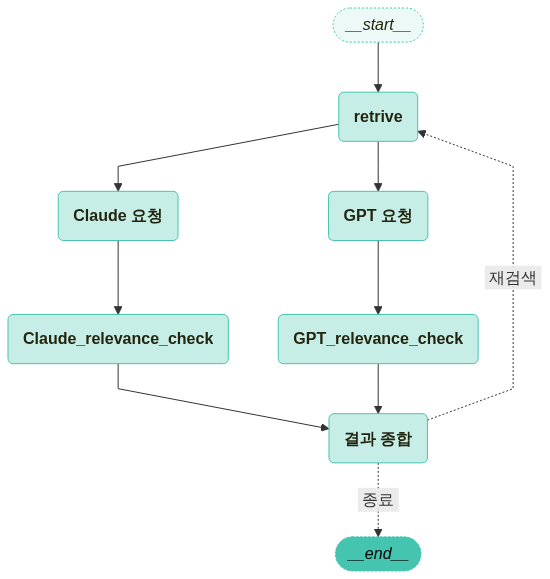

In [7]:
#langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드를 추가 합니다.
workflow.add_node("retrive", retrive)
workflow.add_node("GPT 요청",llm_gpt_execute)
workflow.add_node("Claude 요청",llm_claude_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Claude_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)

# 각 노드를 연결 합니다.
workflow.add_edge("retrive","GPT 요청")
workflow.add_edge("retrive","Claude 요청")
workflow.add_edge("GPT 요청","GPT_relevance_check")
workflow.add_edge("Claude 요청","Claude_relevance_check")
workflow.add_edge("GPT_relevance_check","결과 종합")
workflow.add_edge("Claude_relevance_check","결과 종합")

workflow.add_conditional_edges(
    "결과 종합",
    decision,
    {
        "재검색" : "retrive",
        "종료" : END,
    },
)

workflow.set_entry_point("retrive")
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

visualize_graph(app)

### 4. 3번에 쿼리재작성 노드 추가

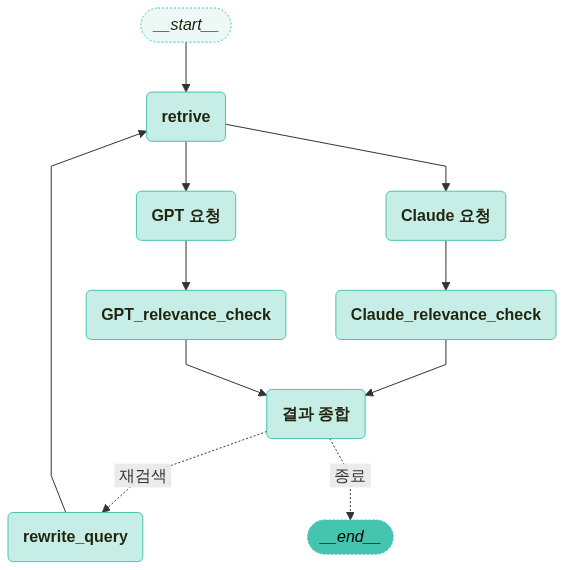

In [8]:
#langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드를 추가 합니다.
workflow.add_node("retrive", retrive)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("GPT 요청",llm_gpt_execute)
workflow.add_node("Claude 요청",llm_claude_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Claude_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)

# 각 노드를 연결 합니다.
workflow.add_edge("retrive","GPT 요청")
workflow.add_edge("retrive","Claude 요청")
workflow.add_edge("rewrite_query","retrive")
workflow.add_edge("GPT 요청","GPT_relevance_check")
workflow.add_edge("Claude 요청","Claude_relevance_check")
workflow.add_edge("GPT_relevance_check","결과 종합")
workflow.add_edge("Claude_relevance_check","결과 종합")

workflow.add_conditional_edges(
    "결과 종합",  # 관련성 체크 노드에서 나온 결과물을 is_relevant 함수에 전달 합니다.
    decision,
    {
        "재검색" : "rewrite_query", # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
        "종료" : END,   # 관련성이 없으면 종료 합니다. 
    },
)

workflow.set_entry_point("retrive")
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

visualize_graph(app)

### 5. SQL RAG

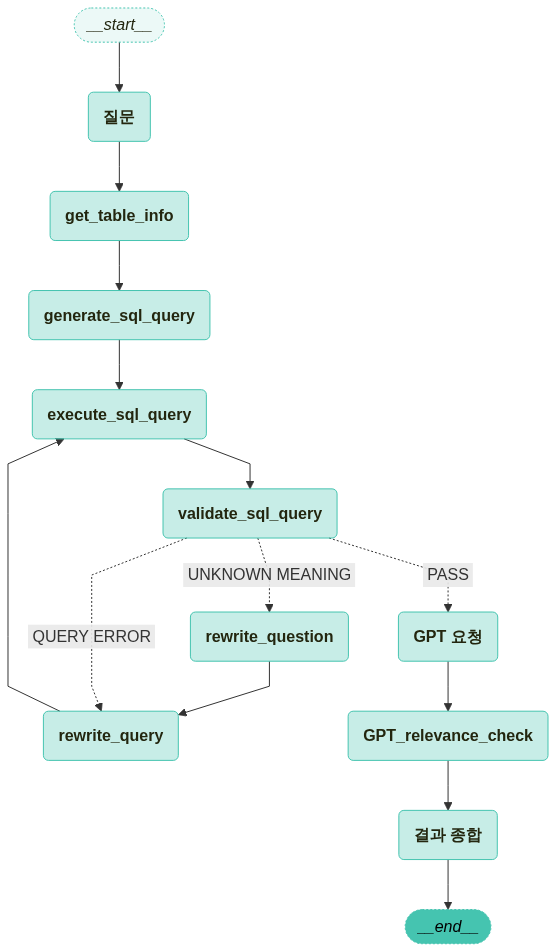

In [9]:
#langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드를 추가 합니다.
workflow.add_node("질문", retrive)
workflow.add_node("get_table_info", get_table_info)
workflow.add_node("generate_sql_query",generate_sql_query)
workflow.add_node("execute_sql_query",execute_sql_query)
workflow.add_node("validate_sql_query", validate_sql_query)
workflow.add_node("rewrite_question", rewrite_query)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("GPT 요청",llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)

# 각 노드를 연결 합니다.
workflow.add_edge("질문","get_table_info")
workflow.add_edge("get_table_info","generate_sql_query")
workflow.add_edge("generate_sql_query","execute_sql_query")
workflow.add_edge("execute_sql_query","validate_sql_query")

workflow.add_conditional_edges(
    "validate_sql_query",  # 관련성 체크 노드에서 나온 결과물을 is_relevant 함수에 전달 합니다.
    decision,
    {
        "UNKNOWN MEANING" : "rewrite_question",
        "QUERY ERROR" : "rewrite_query",
        "PASS" : "GPT 요청",
    },
)

workflow.add_edge("rewrite_question","rewrite_query")
workflow.add_edge("rewrite_query","execute_sql_query")

workflow.add_edge("GPT 요청","GPT_relevance_check")
workflow.add_edge("GPT_relevance_check","결과 종합")
workflow.add_edge("결과 종합",END)

workflow.set_entry_point("질문")
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

visualize_graph(app)

### RAG구현하기(점점 기능 늘리면서 langgraph 사용)

In [10]:
from dotenv import load_dotenv
import os

# .env 파일 로드
load_dotenv()

True

In [6]:
LANGSMITH_TRACING='true'
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY=os.getenv('LANGSMITH_API_KEY')
LANGSMITH_PROJECT="langgraph_test"
OPENAI_API_KEY=os.getenv('OPENAI_API_KEY')

In [8]:
from  langsmith import Client

In [12]:
# pdf 문서 로드
from pdf import PDFRetrievalChain

pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

In [13]:
pdf_retriever

VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002167F9745D0>, search_kwargs={'k': 10})

In [14]:
pdf_chain

{
  question: RunnableLambda(itemgetter('question')),
  context: RunnableLambda(itemgetter('context')),
  chat_history: RunnableLambda(itemgetter('chat_history'))
}
| PromptTemplate(input_variables=['chat_history', 'context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'teddynote', 'lc_hub_repo': 'rag-prompt-chat-history', 'lc_hub_commit_hash': '9ca39c3b3a117e4f8408d51bd71a87fc17fe6fd1d01986c449eecaebc02d549f'}, template="You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. \nYour primary mission is to answer questions based on provided context or chat history.\nEnsure your response is concise and directly addresses the question without any additional narration.\n\n###\n\nYou may consider the previous conversation history to answer the question.\n\n# Here's the previous conversation history:\n{chat_history}\n\n###\n\nYour final answer should be written concisely (but include importan

In [15]:
search_result = pdf.retriever.invoke("이문서는 주로 어떤 내용들이 담겨져 있는거야?")
search_result

[Document(id='06bfdbff-b5ce-4e37-9bf3-62c975d9f61e', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 10, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='데이터로 훈련된 오픈소스 LLM에서는 데이터 라이선스의 누락 비율이 72~83%에 달함\n∙ 또한 크라우드소싱 플랫폼이 할당한 라이선스는 데이터셋 원저작자의 의도보다 더 광범위한 사용을\n허용한 경우가 상당수\n∙ 데이터 생태계 분석 결과, 부정확하거나 모호한 라이선스 문서화 등 데이터 출처 입증과 관련된 관행\n전반에서 구조적 문제가 드러남\nn 연구진은 데이터 출처 탐색기만으로는 해결이 어려운 법적 이슈도 존재한다며 일관된 법적 프레임\n워크의 필요성을 제기'),
 Document(id='87c583e1-bc4f-4647-8c68-fcef97a78cd1', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 22, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:

In [16]:
answer = pdf_chain.invoke(
    {
        "question" : "이문서는 주로 어떤 내용들이 담겨져 있어?",
        "context" : search_result,
        "chat_history" : [],
    }
)
print(answer)

이 문서는 주로 데이터 라이선스, 데이터 투명성, AI 기술 및 산업 동향에 관한 내용을 담고 있습니다. 주요 내용으로는 오픈소스 LLM의 데이터 라이선스 누락 비율(72~83%), 데이터 출처 탐색기 플랫폼의 출시, 그리고 법적 프레임워크의 필요성 등이 포함되어 있습니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 10)


In [ ]:
# state 정의
# State : Graph의 노드간 공유하는 상태를 정의함
# 일반적으로 TypeDict 형식을 사용함

from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

class GRaphState(TypedDict):
    question : Annotated[str, "Question"] # 